# Metalens Surrogate

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd


In [2]:
lda0 = 10.6  # operation wavelength
freq0 = td.C_0 / lda0  # operation frequency
ldas = np.linspace(10.1, 11.1, 101)  # operation wavelength
freqs = td.C_0 / ldas

P = 6.2  # period of the unit cell
h = 6.8  # height of the pillar

inf_eff = 1e5  # effective infinity

In [3]:
n_si = 3.43  # refractive index of silicon
si = td.Medium(permittivity=n_si**2)

In [4]:
def create_ellipsis(major_radius, minor_radius, angle, x_offset, y_offset):
    def generate_ellipse_points(major_radius, minor_radius, x_offset, y_offset, num_points=100):
            """
            Generate points along the boundary of an ellipse.

            Parameters:
            - major_radius (float): The length of the semi-major axis (major radius).
            - minor_radius (float): The length of the semi-minor axis (minor radius).
            - num_points (int): The number of points to generate (default is 100).

            Returns:
            - numpy.ndarray: An array of shape (num_points, 2) containing the (x, y) coordinates of the ellipse.
            """
            t = np.linspace(0, 2 * np.pi, num_points + 1)[:-1] # TH: avoid duplicate points at 0=2pi
            
            # Parametric equations for the ellipse
            x = major_radius * np.cos(t)
            y = minor_radius * np.sin(t)
            
            # Combine x and y into a single array
            points = np.column_stack((x, y))
            
            return points

    angle_rad = np.deg2rad(angle) # define angle in radians for `cos` and `sin` (if input is degrees?)
    vertices = generate_ellipse_points(major_radius, minor_radius, x_offset, y_offset)
    rot_mat = [[np.cos(angle_rad), -np.sin(angle_rad)], [np.sin(angle_rad), np.cos(angle_rad)]]
    vertices_rotated = vertices.dot(rot_mat)

    # Add offset
    vertices_rotated[:, 0] = vertices_rotated[:, 0] + x_offset
    vertices_rotated[:, 1] = vertices_rotated[:, 1] + y_offset
    
    ellipsis = td.Structure(
        geometry=td.PolySlab(vertices=vertices_rotated, axis=2, slab_bounds=(0, h)), medium=si,
    )

    return ellipsis


def make_sim(major_radius, minor_radius, angle):

    # define geometry
    substrate_geo = td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0))
    substrate = td.Structure(geometry=substrate_geo, medium=si, name="substrate")
    
    # Define ellipses
    ellipsis = create_ellipsis(major_radius, minor_radius, angle, 0, 0)

    # add a plane wave source
    plane_wave1 = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
        size=(td.inf, td.inf, 0),
        center=(0, 0, -0.1 * lda0),
        direction="+",
    )

    # add a plane wave source
    # plane_wave2 = td.PlaneWave(
    #     source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10, phase=np.pi/2),
    #     size=(td.inf, td.inf, 0),
    #     center=(0, 0, -0.1 * lda0),
    #     direction="+",
    #     pol_angle=np.pi/2
    # )

    # define a diffraction monitor to calculate the transmission coefficient
    monitor_t = td.DiffractionMonitor(
        center=[0, 0, h + 0.5 * lda0], size=[td.inf, td.inf, 0], freqs=freqs, name="t"
    )

    run_time = 5e-12  # simulation run time

    # define boundary conditions
    boundary_spec = td.BoundarySpec(
        x=td.Boundary.periodic(),
        y=td.Boundary.periodic(),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    Lz = h + 1.2 * lda0  # simulation domain size in z direction
    min_steps_per_wvl = 12  # minimum steps per wavelength for the grid

    # define a function to create unit cell simulation given pillar diameter
    sim = td.Simulation(
        center=(0, 0, h / 2),
        size=(P, P, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0),
        structures=[ellipsis, substrate],
        sources=[plane_wave1],
        monitors=[monitor_t],
        run_time=run_time,
        boundary_spec=boundary_spec,  # pml is applied to z direction. x and y directions are periodic
    )

    return sim

In [1]:
sim = make_sim(1.5, 0.5, 45)
sim.plot_3d()

NameError: name 'make_sim' is not defined

In [6]:
def fn_post(sim_data):
    t = sim_data["t"]
    return {"t": t}

In [7]:
method = tdd.MethodMonteCarlo(
    num_points=100,
    seed=1,
)

maj_r = tdd.ParameterFloat(name="major_radius", span=(0.75, 1.8))
min_r = tdd.ParameterFloat(name="minor_radius", span=(0.75, 1.8))
ang = tdd.ParameterFloat(name="angle", span=(0, 180))
parameters = [maj_r, min_r, ang]

output_dir = "/home/matt/Documents/Flexcompute/metalens_linear_source/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=parameters,
    task_name="metalens_1",
    folder_name="metalensV2",
    path_dir=output_dir,
)


In [57]:
results = design_space.run(make_sim, fn_post, verbose=True)
df = results.to_dataframe()

17:39:26 BST Running 100 Simulations

In [8]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/metalens_linear_source/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

## Surrogate

In [20]:
expanded_df = df.copy()
expanded_df["transmission"] = expanded_df["t"].apply(lambda x: x.amps.sel(polarization="p").squeeze())
expanded_df.drop(["t"], axis=1, inplace=True)
expanded_df = expanded_df.explode(["transmission"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["transmission"].apply(lambda x: float(x.f))

# Complex numbers 
expanded_df["complex"] = expanded_df["transmission"].apply(lambda x: x.data)
expanded_df["real"] = expanded_df["complex"].apply(lambda x: x.real)
expanded_df["imag"] = expanded_df["complex"].apply(lambda x: x.imag)

# Processing
# expanded_df["transmittance"] = expanded_df["transmission"].apply(lambda x: float(np.abs(x)))
# expanded_df["theta"] = expanded_df["transmission"].apply(lambda x: np.unwrap(np.angle(x.expand_dims("f"))).reshape(-1))
# expanded_df["theta"] = expanded_df["theta"].apply(lambda x: float(x[0] / (2 * np.pi)))
# expanded_df["norm_theta"] = expanded_df["theta"].apply(lambda x: (x - expanded_df.theta.min()) / (expanded_df.theta.max() - expanded_df.theta.min()))

print()

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/metalens"
data_dir = ["/home/matt/Documents/Flexcompute/metalens/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 512
epochs = 100

trial_count = 20

model = AI_Model(output_dir, data_dir, seed=1)

model.load_data_from_df(
    df=expanded_df,
    label_names=["real", "imag"],
    feature_names=["major_radius", "minor_radius", "angle", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True
)

loss_fn = nn.MSELoss()

Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


In [22]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 2))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Using existing directory at Model1


  3%|▎         | 3/100 [00:00<00:04, 23.07it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3


  6%|▌         | 6/100 [00:00<00:03, 25.54it/s]

Best State Updated. Epoch: 4
Best State Updated. Epoch: 5


  9%|▉         | 9/100 [00:00<00:03, 26.43it/s]

Best State Updated. Epoch: 6
Best State Updated. Epoch: 7
Best State Updated. Epoch: 8
Best State Updated. Epoch: 9


 12%|█▏        | 12/100 [00:00<00:03, 25.72it/s]

Best State Updated. Epoch: 10
Best State Updated. Epoch: 11


 15%|█▌        | 15/100 [00:00<00:03, 26.39it/s]

Best State Updated. Epoch: 12
Best State Updated. Epoch: 13
Best State Updated. Epoch: 14
Best State Updated. Epoch: 15


 18%|█▊        | 18/100 [00:00<00:03, 26.00it/s]

Best State Updated. Epoch: 16
Best State Updated. Epoch: 17


 24%|██▍       | 24/100 [00:01<00:03, 20.56it/s]

Best State Updated. Epoch: 18
Best State Updated. Epoch: 19
Best State Updated. Epoch: 20
Best State Updated. Epoch: 21
Best State Updated. Epoch: 22
Best State Updated. Epoch: 23


 30%|███       | 30/100 [00:01<00:03, 23.21it/s]

Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26
Best State Updated. Epoch: 27
Best State Updated. Epoch: 28
Best State Updated. Epoch: 29


 36%|███▌      | 36/100 [00:01<00:02, 25.32it/s]

Best State Updated. Epoch: 30
Best State Updated. Epoch: 31
Best State Updated. Epoch: 32
Best State Updated. Epoch: 33
Best State Updated. Epoch: 34
Best State Updated. Epoch: 35


 42%|████▏     | 42/100 [00:01<00:02, 25.58it/s]

Best State Updated. Epoch: 36
Best State Updated. Epoch: 37
Best State Updated. Epoch: 38
Best State Updated. Epoch: 39
Best State Updated. Epoch: 40
Best State Updated. Epoch: 41


 48%|████▊     | 48/100 [00:01<00:01, 26.41it/s]

Best State Updated. Epoch: 42
Best State Updated. Epoch: 43
Best State Updated. Epoch: 44
Best State Updated. Epoch: 45
Best State Updated. Epoch: 46


 54%|█████▍    | 54/100 [00:02<00:01, 26.92it/s]

Best State Updated. Epoch: 49
Best State Updated. Epoch: 50
Best State Updated. Epoch: 51
Best State Updated. Epoch: 52
Best State Updated. Epoch: 53
Best State Updated. Epoch: 54


 60%|██████    | 60/100 [00:02<00:01, 26.95it/s]

Best State Updated. Epoch: 55
Best State Updated. Epoch: 56
Best State Updated. Epoch: 59
Best State Updated. Epoch: 60


 66%|██████▌   | 66/100 [00:02<00:01, 26.57it/s]

Best State Updated. Epoch: 61
Best State Updated. Epoch: 62
Best State Updated. Epoch: 63
Best State Updated. Epoch: 66


 69%|██████▉   | 69/100 [00:02<00:01, 25.09it/s]

Best State Updated. Epoch: 67
Best State Updated. Epoch: 68
Best State Updated. Epoch: 69
Best State Updated. Epoch: 70


 78%|███████▊  | 78/100 [00:03<00:00, 23.21it/s]

Best State Updated. Epoch: 72
Best State Updated. Epoch: 73
Best State Updated. Epoch: 74
Best State Updated. Epoch: 75
Best State Updated. Epoch: 76
Best State Updated. Epoch: 77


 87%|████████▋ | 87/100 [00:03<00:00, 25.17it/s]

Best State Updated. Epoch: 81
Best State Updated. Epoch: 82
Best State Updated. Epoch: 83
Best State Updated. Epoch: 84
Best State Updated. Epoch: 86


 93%|█████████▎| 93/100 [00:03<00:00, 25.88it/s]

Best State Updated. Epoch: 87
Best State Updated. Epoch: 88
Best State Updated. Epoch: 89
Best State Updated. Epoch: 90
Best State Updated. Epoch: 91
Best State Updated. Epoch: 92


 99%|█████████▉| 99/100 [00:04<00:00, 26.55it/s]

Best State Updated. Epoch: 94
Best State Updated. Epoch: 95
Best State Updated. Epoch: 96
Best State Updated. Epoch: 97
Best State Updated. Epoch: 99


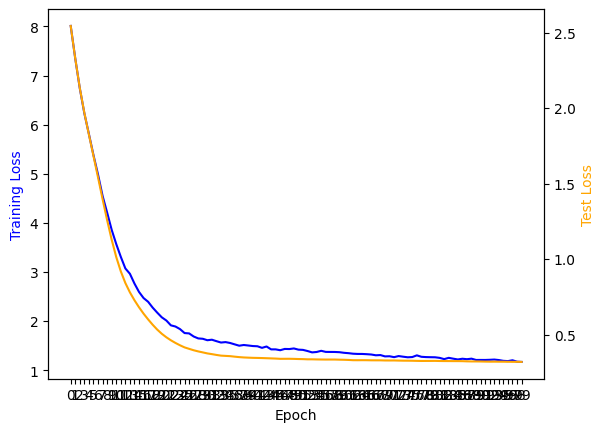

100%|██████████| 100/100 [00:04<00:00, 22.91it/s]

 Best Test Loss: 0.31834903359413147
RMSE: 0.449125
MAE: 0.387065


In [23]:
# Create single model
network = VariableANN(4, [4, 4, 4], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, epochs, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

[I 2024-08-29 10:23:29,087] A new study created in memory with name: no-name-76fd4c56-1ae5-498c-ae1d-772a7d87e339


Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:04<00:00, 24.87it/s]
[I 2024-08-29 10:23:33,124] Trial 0 finished with value: 0.421548 and parameters: {'dropout': 0.2, 'neurons0': 192, 'neurons1': 16, 'neurons2': 80, 'neurons3': 48, 'lr': 2.3407464805767515e-05, 'weight_decay': 2.3578730726467393e-05}. Best is trial 0 with value: 0.421548.


 Best Test Loss: 0.2787172496318817
RMSE: 0.421548
MAE: 0.360348
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.27it/s]
[I 2024-08-29 10:23:37,096] Trial 1 finished with value: 0.248894 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 112, 'neurons1': 144, 'neurons2': 112, 'neurons3': 176, 'lr': 6.573686655138327e-05, 'weight_decay': 0.0005704727088203682}. Best is trial 1 with value: 0.248894.


 Best Test Loss: 0.09759647399187088
RMSE: 0.248894
MAE: 0.189734
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 26.17it/s]
[I 2024-08-29 10:23:40,932] Trial 2 finished with value: 0.239223 and parameters: {'dropout': 0.0, 'neurons0': 176, 'neurons1': 112, 'neurons2': 144, 'neurons3': 48, 'lr': 6.200203677164716e-05, 'weight_decay': 0.00039947456945609163}. Best is trial 2 with value: 0.239223.


 Best Test Loss: 0.09045276045799255
RMSE: 0.239223
MAE: 0.188178
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.03it/s]
[I 2024-08-29 10:23:44,941] Trial 3 finished with value: 0.504777 and parameters: {'dropout': 0.5, 'neurons0': 96, 'neurons1': 192, 'neurons2': 240, 'neurons3': 240, 'lr': 2.1886526657465428e-05, 'weight_decay': 1.197042490409919e-05}. Best is trial 2 with value: 0.239223.


 Best Test Loss: 0.3858867287635803
RMSE: 0.504777
MAE: 0.409286
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.81it/s]
[I 2024-08-29 10:23:48,830] Trial 4 finished with value: 0.072901 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 32, 'neurons2': 112, 'neurons3': 256, 'lr': 0.0013572540301313666, 'weight_decay': 0.00024196593469527324}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.007390904240310192
RMSE: 0.072901
MAE: 0.054267
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.91it/s]
[I 2024-08-29 10:23:52,705] Trial 5 finished with value: 0.451734 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 176, 'neurons1': 224, 'neurons2': 16, 'neurons3': 208, 'lr': 0.0902494067192741, 'weight_decay': 0.0003135676915341995}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.3211265802383423
RMSE: 0.451734
MAE: 0.391437
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 26.18it/s]
[I 2024-08-29 10:23:56,540] Trial 6 finished with value: 0.135357 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 208, 'neurons1': 32, 'neurons2': 128, 'neurons3': 240, 'lr': 0.0001494364677378836, 'weight_decay': 3.763142612534587e-05}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.02876146137714386
RMSE: 0.135357
MAE: 0.098423
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.12it/s]
[I 2024-08-29 10:24:00,535] Trial 7 finished with value: 0.083982 and parameters: {'dropout': 0.05, 'neurons0': 16, 'neurons1': 176, 'neurons2': 64, 'neurons3': 80, 'lr': 0.0009253214657642581, 'weight_decay': 1.2785717080546074e-05}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.01071864552795887
RMSE: 0.083982
MAE: 0.065513
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.13it/s]
[I 2024-08-29 10:24:04,529] Trial 8 finished with value: 0.159299 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 48, 'neurons1': 160, 'neurons2': 192, 'neurons3': 32, 'lr': 0.00045313118440918, 'weight_decay': 0.0002447937444286876}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.039849698543548584
RMSE: 0.159299
MAE: 0.128169
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:04<00:00, 24.79it/s]
[I 2024-08-29 10:24:08,577] Trial 9 finished with value: 0.42565 and parameters: {'dropout': 0.2, 'neurons0': 16, 'neurons1': 144, 'neurons2': 176, 'neurons3': 144, 'lr': 0.06003147633638411, 'weight_decay': 0.00014897386352200276}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.2837679386138916
RMSE: 0.42565
MAE: 0.365459
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.25it/s]
[I 2024-08-29 10:24:12,573] Trial 10 finished with value: 0.149107 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 256, 'neurons1': 80, 'neurons2': 256, 'neurons3': 112, 'lr': 0.004852851779481773, 'weight_decay': 7.327696145109403e-05}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.03190835192799568
RMSE: 0.149107
MAE: 0.122386
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.31it/s]
[I 2024-08-29 10:24:16,558] Trial 11 finished with value: 0.109358 and parameters: {'dropout': 0.0, 'neurons0': 64, 'neurons1': 256, 'neurons2': 48, 'neurons3': 96, 'lr': 0.0029114863197187714, 'weight_decay': 0.000927518876196669}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.018306948244571686
RMSE: 0.109358
MAE: 0.07878
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.77it/s]
[I 2024-08-29 10:24:20,473] Trial 12 finished with value: 0.047326 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 80, 'neurons2': 80, 'neurons3': 96, 'lr': 0.0016690219230360306, 'weight_decay': 8.808234772855056e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.003400420071557164
RMSE: 0.047326
MAE: 0.03618
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.47it/s]
[I 2024-08-29 10:24:24,433] Trial 13 finished with value: 0.08192 and parameters: {'dropout': 0.05, 'neurons0': 256, 'neurons1': 64, 'neurons2': 96, 'neurons3': 160, 'lr': 0.012280238476692185, 'weight_decay': 9.031660557043444e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.0047424230724573135
RMSE: 0.08192
MAE: 0.066833
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 26.25it/s]
[I 2024-08-29 10:24:28,275] Trial 14 finished with value: 0.095323 and parameters: {'dropout': 0.1, 'neurons0': 240, 'neurons1': 64, 'neurons2': 16, 'neurons3': 192, 'lr': 0.0004411438203421464, 'weight_decay': 0.00015502807726359776}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.014221004210412502
RMSE: 0.095323
MAE: 0.070987
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:04<00:00, 24.67it/s]
[I 2024-08-29 10:24:32,363] Trial 15 finished with value: 0.093463 and parameters: {'dropout': 0.4, 'neurons0': 144, 'neurons1': 96, 'neurons2': 160, 'neurons3': 128, 'lr': 0.0027987712349286987, 'weight_decay': 4.338916893941725e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.01167311891913414
RMSE: 0.093463
MAE: 0.07404
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.65it/s]
[I 2024-08-29 10:24:36,295] Trial 16 finished with value: 0.067496 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 48, 'neurons2': 48, 'neurons3': 80, 'lr': 0.015179552139523395, 'weight_decay': 0.0001584552270614731}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.005145263858139515
RMSE: 0.067496
MAE: 0.050251
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.58it/s]
[I 2024-08-29 10:24:40,237] Trial 17 finished with value: 0.088257 and parameters: {'dropout': 0.1, 'neurons0': 208, 'neurons1': 112, 'neurons2': 48, 'neurons3': 80, 'lr': 0.017769388271320966, 'weight_decay': 5.5361196314057384e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.011035498231649399
RMSE: 0.088257
MAE: 0.068797
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.39it/s]
[I 2024-08-29 10:24:44,210] Trial 18 finished with value: 0.141097 and parameters: {'dropout': 0.25, 'neurons0': 144, 'neurons1': 48, 'neurons2': 48, 'neurons3': 16, 'lr': 0.017501583911323126, 'weight_decay': 0.0001352501384480692}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.031186824664473534
RMSE: 0.141097
MAE: 0.113216
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.90it/s]
[I 2024-08-29 10:24:48,104] Trial 19 finished with value: 0.040549 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 112, 'neurons2': 80, 'neurons3': 64, 'lr': 0.00717673527173512, 'weight_decay': 2.4204161752957207e-05}. Best is trial 19 with value: 0.040549.


 Best Test Loss: 0.0009550366667099297
RMSE: 0.040549
MAE: 0.029562
Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  0.040549
  Params: 
    dropout: 0.0
    neurons0: 224
    neurons1: 112
    neurons2: 80
    neurons3: 64
    lr: 0.00717673527173512
    weight_decay: 2.4204161752957207e-05
Using existing directory at Model1


  0%|          | 3/1000 [00:00<00:35, 27.87it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3
Best State Updated. Epoch: 4


  1%|          | 6/1000 [00:00<00:35, 27.63it/s]

Best State Updated. Epoch: 5


  1%|          | 9/1000 [00:00<00:35, 27.64it/s]

Best State Updated. Epoch: 6
Best State Updated. Epoch: 7
Best State Updated. Epoch: 8
Best State Updated. Epoch: 9


  1%|          | 12/1000 [00:00<00:35, 27.51it/s]

Best State Updated. Epoch: 11


  2%|▏         | 15/1000 [00:00<00:35, 27.59it/s]

Best State Updated. Epoch: 12
Best State Updated. Epoch: 13
Best State Updated. Epoch: 14
Best State Updated. Epoch: 15


  2%|▏         | 21/1000 [00:00<00:44, 22.19it/s]

Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 18
Best State Updated. Epoch: 19


  3%|▎         | 27/1000 [00:01<00:39, 24.90it/s]

Best State Updated. Epoch: 23
Best State Updated. Epoch: 24
Best State Updated. Epoch: 26


  4%|▎         | 36/1000 [00:01<00:35, 27.04it/s]

Best State Updated. Epoch: 30
Best State Updated. Epoch: 31


  4%|▍         | 42/1000 [00:01<00:34, 27.65it/s]

Best State Updated. Epoch: 36
Best State Updated. Epoch: 37
Best State Updated. Epoch: 39


  5%|▌         | 54/1000 [00:02<00:34, 27.71it/s]

Best State Updated. Epoch: 48
Best State Updated. Epoch: 49
Best State Updated. Epoch: 51


  7%|▋         | 69/1000 [00:02<00:34, 27.29it/s]

Best State Updated. Epoch: 64
Best State Updated. Epoch: 66
Best State Updated. Epoch: 67


  8%|▊         | 75/1000 [00:02<00:41, 22.10it/s]

Best State Updated. Epoch: 71


  8%|▊         | 84/1000 [00:03<00:37, 24.49it/s]

Best State Updated. Epoch: 79
Best State Updated. Epoch: 80
Best State Updated. Epoch: 81
Best State Updated. Epoch: 82


 10%|█         | 102/1000 [00:03<00:33, 27.05it/s]

Best State Updated. Epoch: 96


 14%|█▍        | 138/1000 [00:05<00:31, 27.08it/s]

Best State Updated. Epoch: 134
Best State Updated. Epoch: 136
Best State Updated. Epoch: 137


 25%|██▍       | 249/1000 [00:09<00:27, 26.85it/s]

Best State Updated. Epoch: 243
Best State Updated. Epoch: 248


 32%|███▏      | 324/1000 [00:12<00:24, 27.76it/s]

Best State Updated. Epoch: 320


 42%|████▏     | 417/1000 [00:15<00:21, 27.09it/s]

Best State Updated. Epoch: 412
Best State Updated. Epoch: 413


 51%|█████▏    | 513/1000 [00:19<00:18, 26.18it/s]

Best State Updated. Epoch: 509


 53%|█████▎    | 528/1000 [00:20<00:17, 26.59it/s]

Best State Updated. Epoch: 523


 56%|█████▌    | 555/1000 [00:21<00:18, 24.65it/s]

Best State Updated. Epoch: 549


 58%|█████▊    | 582/1000 [00:22<00:15, 27.00it/s]

Best State Updated. Epoch: 578


 62%|██████▏   | 615/1000 [00:23<00:15, 25.52it/s]

Best State Updated. Epoch: 610
Best State Updated. Epoch: 611
Best State Updated. Epoch: 612
Best State Updated. Epoch: 613
Best State Updated. Epoch: 614


 91%|█████████ | 912/1000 [00:35<00:03, 26.69it/s]

Best State Updated. Epoch: 906
Best State Updated. Epoch: 907


100%|█████████▉| 999/1000 [00:38<00:00, 28.46it/s]

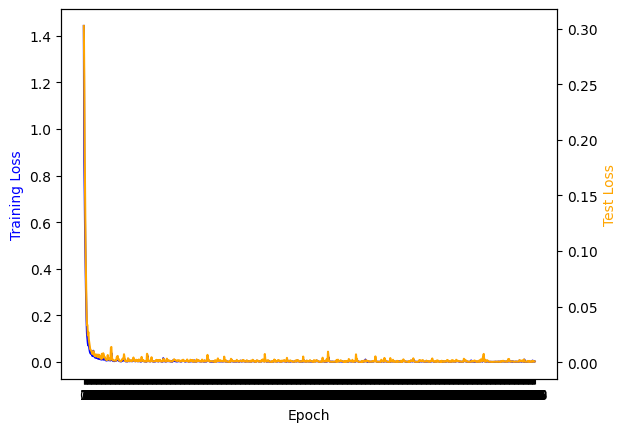

100%|██████████| 1000/1000 [00:41<00:00, 24.20it/s]

 Best Test Loss: 0.00029806705424562097


In [24]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 4},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 16, "high": 256, "step": 16, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 1000, plot_output=True)

In [25]:
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

RMSE: 0.021364
MAE: 0.016799


## Optimization

In [47]:
def run_fn(major_radius, minor_radius, angle, target_phi):
    freq = freq0
    feature_array = np.array((major_radius, minor_radius, angle, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)
    comp_num = prediction[0] + prediction[1] * 1j
    transmission = np.abs(comp_num)
    theta = np.angle(comp_num)

    return transmission * np.cos(target_phi - theta)

Determine desired metalens values

The number of unit cells is 7396.
The diameter of the metalens is 1.060 mm. The focal length is 0.707 mm.


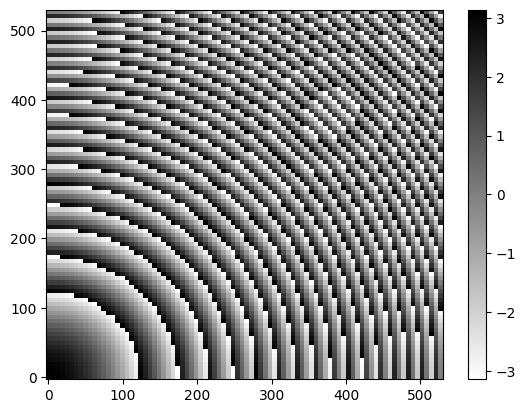

In [48]:
R = 50 * lda0  # radius of the designed metalens

# define a grid of cells
r = np.arange(0, R, P)
print(f"The number of unit cells is {len(r)**2}.")
X, Y = np.meshgrid(r, r)

NA = 0.6  # numerical aperture of the designed metalens

f = R / NA * np.sqrt(1 - NA**2)  # focal length
print(f"The diameter of the metalens is {2*R/1e3:.3f} mm. The focal length is {f/1e3:.3f} mm.")

# desired phase profile
phi_map = (2 * np.pi * (f - np.sqrt(X**2 + Y**2 + f**2)) / lda0) % (-2 * np.pi) + np.pi

# plot the desired phase profile
plt.pcolormesh(X, Y, phi_map, cmap="binary")
plt.colorbar()
plt.show()

Break the phi map down into X points and optimise structures for those points

In [68]:
optimization_points = 100
phi_range = np.linspace(phi_map.min(), phi_map.max(), optimization_points)

In [70]:
phi_dict = {}
for target_phi in phi_range:
    # Design space defined new each time 
    method = tdd.MethodBayOpt(
        initial_iter=300,
        n_iter=25,
        acq_func='ucb',
        kappa=0.5,
        xi=0.9,
        seed=1,
    )

    # Easiest way to get target_phi into the optimization
    predict_parameters = parameters + [tdd.ParameterFloat(name="target_phi", span=(target_phi, target_phi))]

    output_dir = "/home/matt/Documents/Flexcompute/metalens2/data"
    design_space = tdd.DesignSpace(
        method=method,
        parameters=predict_parameters,
        task_name="metalens_predict_1",
        folder_name="MetalensV2",
        path_dir=output_dir,
    )
    
    predict_results = design_space.run(run_fn, verbose=True)
    phi_dict[target_phi] = predict_results.optimizer.max['params'].values()

12:26:01 BST Best Fit from Initial Solutions: 0.837                             
             

12:26:15 BST Latest Best Fit on Iter 28: 0.84                                   
             

12:26:25 BST Best Result: 0.8403479200532057                                    
             Best Parameters: angle: 28.31502302427111 major_radius: 0.75       
             minor_radius: 0.7800650170455885 target_phi: -3.1414122660566726   
             

             Best Fit from Initial Solutions: 0.848                             
             

12:26:49 BST Best Result: 0.8477276695749547                                    
             Best Parameters: angle: 3.578424091163206 major_radius:            
             0.7775215362216052 minor_radius: 0.7797218124218344 target_phi:    
             -3.0779475698986274                                                
             

             Best Fit from Initial Solutions: 0.855                             
             

12:27:06 BST Latest Best Fit on Iter 33: 0.857                                  
             

12:27:12 BST Latest Best Fit on Iter 46: 0.861                                  
             

12:27:13 BST Best Result: 0.8607810542919729                                    
             Best Parameters: angle: 28.30832196182183 major_radius: 0.75       
             minor_radius: 0.7627216229044429 target_phi: -3.014482873740582    
             

             Best Fit from Initial Solutions: 0.86                              
             

12:27:29 BST Latest Best Fit on Iter 33: 0.86                                   
             

12:27:36 BST Best Result: 0.8604198336453642                                    
             Best Parameters: angle: 51.91978738470706 major_radius:            
             0.7690454800311437 minor_radius: 0.7586984078908847 target_phi:    
             -2.9510181775825375                                                
             

             Best Fit from Initial Solutions: 0.86                              
             

12:28:01 BST Latest Best Fit on Iter 49: 0.863                                  
             

             Best Result: 0.8627290986510897                                    
             Best Parameters: angle: 28.314888472160185 major_radius: 0.75      
             minor_radius: 0.762156898878364 target_phi: -2.8875534814244923    
             

             Best Fit from Initial Solutions: 0.859                             
             

12:28:07 BST Latest Best Fit on Iter 13: 0.86                                   
             

12:28:21 BST Latest Best Fit on Iter 43: 0.86                                   
             

12:28:25 BST Best Result: 0.8597188349570071                                    
             Best Parameters: angle: 28.287704568879082 major_radius:           
             0.8284215725295968 minor_radius: 0.7564022933920767 target_phi:    
             -2.824088785266447                                                 
             

             Best Fit from Initial Solutions: 0.86                              
             

12:28:48 BST Best Result: 0.8604574330889806                                    
             Best Parameters: angle: 25.816148760644083 major_radius:           
             0.8323062448476953 minor_radius: 0.7692492750586577 target_phi:    
             -2.760624089108402                                                 
             

             Best Fit from Initial Solutions: 0.858                             
             

12:29:10 BST Latest Best Fit on Iter 47: 0.861                                  
             

12:29:11 BST Best Result: 0.8605268276705214                                    
             Best Parameters: angle: 31.390651281377018 major_radius:           
             0.860311534082995 minor_radius: 0.7810915962939358 target_phi:     
             -2.697159392950357                                                 
             

             Best Fit from Initial Solutions: 0.861                             
             

12:29:16 BST Latest Best Fit on Iter 9: 0.861                                   
             

12:29:35 BST Best Result: 0.8614055187686532                                    
             Best Parameters: angle: 25.73537092332045 major_radius:            
             0.8931967219617722 minor_radius: 0.8236957960529733 target_phi:    
             -2.6336946967923116                                                
             

             Best Fit from Initial Solutions: 0.862                             
             

12:29:40 BST Latest Best Fit on Iter 9: 0.862                                   
             

12:29:45 BST Latest Best Fit on Iter 18: 0.863                                  
             

12:30:00 BST Best Result: 0.8634643670783662                                    
             Best Parameters: angle: 31.39223783150952 major_radius:            
             0.8980559356877982 minor_radius: 0.8290659928865419 target_phi:    
             -2.5702300006342664                                                
             

             Best Fit from Initial Solutions: 0.863                             
             

12:30:26 BST Best Result: 0.8630341953611135                                    
             Best Parameters: angle: 31.312020002483585 major_radius:           
             0.8826459954116193 minor_radius: 0.8918331159490679 target_phi:    
             -2.5067653044762217                                                
             

             Best Fit from Initial Solutions: 0.86                              
             

12:30:27 BST Latest Best Fit on Iter 0: 0.861                                   
             

12:30:33 BST Latest Best Fit on Iter 14: 0.866                                  
             

12:30:50 BST Best Result: 0.8656625058095095                                    
             Best Parameters: angle: 31.48918058888724 major_radius:            
             0.9463376136241586 minor_radius: 0.8856919152691112 target_phi:    
             -2.4433006083181765                                                
             

             Best Fit from Initial Solutions: 0.859                             
             

12:30:51 BST Latest Best Fit on Iter 0: 0.866                                   
             

12:30:57 BST Latest Best Fit on Iter 14: 0.867                                  
             

12:31:13 BST Best Result: 0.8665704554887225                                    
             Best Parameters: angle: 31.48918058888724 major_radius:            
             0.9463376136241586 minor_radius: 0.8856919152691112 target_phi:    
             -2.3798359121601314                                                
             

12:31:14 BST Best Fit from Initial Solutions: 0.857                             
             

             Latest Best Fit on Iter 0: 0.867                                   
             

12:31:16 BST Latest Best Fit on Iter 4: 0.868                                   
             

12:31:39 BST Best Result: 0.8677227539888387                                    
             Best Parameters: angle: 25.746953039132315 major_radius:           
             0.9820603329489637 minor_radius: 0.9090316306450379 target_phi:    
             -2.316371216002086                                                 
             

             Best Fit from Initial Solutions: 0.851                             
             

             Latest Best Fit on Iter 0: 0.864                                   
             

12:31:40 BST Latest Best Fit on Iter 4: 0.868                                   
             

12:32:03 BST Best Result: 0.8683739968723249                                    
             Best Parameters: angle: 25.746953039132315 major_radius:           
             0.9820603329489637 minor_radius: 0.9090316306450379 target_phi:    
             -2.252906519844041                                                 
             

             Best Fit from Initial Solutions: 0.841                             
             

             Latest Best Fit on Iter 0: 0.859                                   
             

12:32:04 BST Latest Best Fit on Iter 4: 0.866                                   
             

12:32:25 BST Best Result: 0.8655288048611146                                    
             Best Parameters: angle: 25.746953039132315 major_radius:           
             0.9820603329489637 minor_radius: 0.9090316306450379 target_phi:    
             -2.189441823685996                                                 
             

             Best Fit from Initial Solutions: 0.836                             
             

             Latest Best Fit on Iter 0: 0.849                                   
             

12:32:27 BST Latest Best Fit on Iter 4: 0.859                                   
             

12:32:47 BST Best Result: 0.8591986338816472                                    
             Best Parameters: angle: 25.746953039132315 major_radius:           
             0.9820603329489637 minor_radius: 0.9090316306450379 target_phi:    
             -2.1259771275279506                                                
             

             Best Fit from Initial Solutions: 0.839                             
             

12:32:50 BST Latest Best Fit on Iter 5: 0.847                                   
             

12:32:53 BST Latest Best Fit on Iter 13: 0.852                                  
             

12:33:10 BST Best Result: 0.8520493323641862                                    
             Best Parameters: angle: 31.64242795561828 major_radius:            
             1.0064678719923954 minor_radius: 0.9171011373747545 target_phi:    
             -2.062512431369906                                                 
             

12:33:11 BST Best Fit from Initial Solutions: 0.839                             
             

12:33:13 BST Latest Best Fit on Iter 5: 0.843                                   
             

12:33:32 BST Best Result: 0.8432834461130801                                    
             Best Parameters: angle: 29.112942469517023 major_radius:           
             1.0049983684511008 minor_radius: 0.9704776043322242 target_phi:    
             -1.9990477352118607                                                
             

             Best Fit from Initial Solutions: 0.835                             
             

12:33:51 BST Latest Best Fit on Iter 49: 0.839                                  
             

             Best Result: 0.8387065241658047                                    
             Best Parameters: angle: 29.09444062281509 major_radius:            
             1.0424246460953868 minor_radius: 0.9666359853583701 target_phi:    
             -1.9355830390538156                                                
             

             Best Fit from Initial Solutions: 0.828                             
             

12:34:01 BST Latest Best Fit on Iter 21: 0.829                                  
             

12:34:06 BST Latest Best Fit on Iter 28: 0.833                                  
             

12:34:16 BST Best Result: 0.8334226273130404                                    
             Best Parameters: angle: 29.051861043423763 major_radius:           
             1.0356737070661444 minor_radius: 0.9714326454906653 target_phi:    
             -1.8721183428957704                                                
             

             Best Fit from Initial Solutions: 0.818                             
             

12:34:38 BST Best Result: 0.8180531797882299                                    
             Best Parameters: angle: 177.18902103483194 major_radius:           
             0.9812459374671139 minor_radius: 1.1056434267557638 target_phi:    
             -1.8086536467377254                                                
             

             Best Fit from Initial Solutions: 0.806                             
             

12:34:48 BST Latest Best Fit on Iter 22: 0.812                                  
             

12:34:51 BST Latest Best Fit on Iter 28: 0.816                                  
             

12:35:00 BST Best Result: 0.8164012648723581                                    
             Best Parameters: angle: 29.104377410416873 major_radius:           
             1.0475276515791565 minor_radius: 0.9840360689270831 target_phi:    
             -1.7451889505796803                                                
             

             Best Fit from Initial Solutions: 0.81                              
             

12:35:05 BST Latest Best Fit on Iter 11: 0.813                                  
             

12:35:24 BST Best Result: 0.8132151541310312                                    
             Best Parameters: angle: 94.73496345641182 major_radius:            
             0.8326916778996365 minor_radius: 1.139239824543976 target_phi:     
             -1.681724254421635                                                 
             

             Best Fit from Initial Solutions: 0.81                              
             

12:35:38 BST Latest Best Fit on Iter 30: 0.819                                  
             

12:35:46 BST Best Result: 0.8191379326443978                                    
             Best Parameters: angle: 88.12823220009327 major_radius:            
             0.7865625328050233 minor_radius: 1.186105556308588 target_phi:     
             -1.6182595582635901                                                
             

             Best Fit from Initial Solutions: 0.807                             
             

12:35:57 BST Latest Best Fit on Iter 23: 0.814                                  
             

12:36:09 BST Best Result: 0.814313178407811                                     
             Best Parameters: angle: 94.71960061815602 major_radius:            
             0.8878029427902191 minor_radius: 1.1372888665120529 target_phi:    
             -1.554794862105545                                                 
             

             Best Fit from Initial Solutions: 0.801                             
             

12:36:21 BST Latest Best Fit on Iter 25: 0.811                                  
             

12:36:32 BST Best Result: 0.8112299043422642                                    
             Best Parameters: angle: 94.71195563765393 major_radius:            
             0.8902037172095472 minor_radius: 1.1579561710332762 target_phi:    
             -1.4913301659474998                                                
             

             Best Fit from Initial Solutions: 0.792                             
             

12:36:38 BST Latest Best Fit on Iter 13: 0.798                                  
             

12:36:42 BST Latest Best Fit on Iter 18: 0.808                                  
             

12:36:45 BST Latest Best Fit on Iter 23: 0.81                                   
             

12:36:57 BST Best Result: 0.8101191466938792                                    
             Best Parameters: angle: 94.72426652992647 major_radius:            
             0.9047403466287769 minor_radius: 1.1686673350464467 target_phi:    
             -1.4278654697894546                                                
             

             Best Fit from Initial Solutions: 0.779                             
             

12:37:08 BST Latest Best Fit on Iter 23: 0.807                                  
             

12:37:12 BST Latest Best Fit on Iter 31: 0.812                                  
             

12:37:20 BST Best Result: 0.812479272931189                                     
             Best Parameters: angle: 76.8556856857871 major_radius:             
             0.9393587012694516 minor_radius: 1.1449810219653034 target_phi:    
             -1.3644007736314097                                                
             

             Best Fit from Initial Solutions: 0.772                             
             

12:37:28 BST Latest Best Fit on Iter 18: 0.818                                  
             

12:37:43 BST Best Result: 0.817890260972584                                     
             Best Parameters: angle: 94.68532196879409 major_radius:            
             0.8940250984344785 minor_radius: 1.1814864834523027 target_phi:    
             -1.3009360774733645                                                
             

             Best Fit from Initial Solutions: 0.774                             
             

12:37:49 BST Latest Best Fit on Iter 14: 0.789                                  
             

12:37:51 BST Latest Best Fit on Iter 18: 0.818                                  
             

12:38:07 BST Best Result: 0.8178591102912881                                    
             Best Parameters: angle: 94.68532196879409 major_radius:            
             0.8940250984344785 minor_radius: 1.1814864834523027 target_phi:    
             -1.2374713813153193                                                
             

             Best Fit from Initial Solutions: 0.772                             
             

12:38:08 BST Latest Best Fit on Iter 0: 0.774                                   
             

12:38:12 BST Latest Best Fit on Iter 9: 0.781                                   
             

12:38:18 BST Latest Best Fit on Iter 20: 0.809                                  
             

12:38:33 BST Best Result: 0.8092465098991983                                    
             Best Parameters: angle: 94.73085599990593 major_radius:            
             0.8780337621775458 minor_radius: 1.1787543112212384 target_phi:    
             -1.1740066851572744                                                
             

             Best Fit from Initial Solutions: 0.771                             
             

             Latest Best Fit on Iter 0: 0.776                                   
             

12:38:52 BST Latest Best Fit on Iter 33: 0.781                                  
             

12:39:00 BST Best Result: 0.7814931093320333                                    
             Best Parameters: angle: 7.938212230597941 major_radius:            
             1.1291643355731904 minor_radius: 1.0506295521065239 target_phi:    
             -1.1105419889992292                                                
             

12:39:01 BST Best Fit from Initial Solutions: 0.768                             
             

             Latest Best Fit on Iter 0: 0.775                                   
             

12:39:20 BST Latest Best Fit on Iter 33: 0.775                                  
             

12:39:27 BST Best Result: 0.7751273812104089                                    
             Best Parameters: angle: 7.938212230597941 major_radius:            
             1.1291643355731904 minor_radius: 1.0506295521065239 target_phi:    
             -1.047077292841184                                                 
             

             Best Fit from Initial Solutions: 0.761                             
             

12:39:28 BST Latest Best Fit on Iter 0: 0.771                                   
             

12:39:55 BST Best Result: 0.7707191052808522                                    
             Best Parameters: angle: 91.43029247745397 major_radius:            
             0.9952764013463014 minor_radius: 1.153200973670343 target_phi:     
             -0.9836125966831388                                                
             

             Best Fit from Initial Solutions: 0.751                             
             

12:39:56 BST Latest Best Fit on Iter 0: 0.764                                   
             

12:40:19 BST Latest Best Fit on Iter 45: 0.777                                  
             

12:40:21 BST Best Result: 0.7771988628265913                                    
             Best Parameters: angle: 7.848733375215255 major_radius:            
             1.1466461804731811 minor_radius: 1.082747055494274 target_phi:     
             -0.9201479005250937                                                
             

             Best Fit from Initial Solutions: 0.738                             
             

12:40:32 BST Latest Best Fit on Iter 23: 0.75                                   
             

12:40:45 BST Latest Best Fit on Iter 49: 0.77                                   
             

             Best Result: 0.7701870196283286                                    
             Best Parameters: angle: 92.95843696808467 major_radius:            
             0.7950012998105312 minor_radius: 1.285016458537182 target_phi:     
             -0.8566832043670489                                                
             

12:40:46 BST Best Fit from Initial Solutions: 0.723                             
             

             Latest Best Fit on Iter 0: 0.759                                   
             

12:41:11 BST Best Result: 0.7585011630939618                                    
             Best Parameters: angle: 92.99704016433822 major_radius:            
             0.8350068345897319 minor_radius: 1.2989282389777892 target_phi:    
             -0.7932185082090037                                                
             

             Best Fit from Initial Solutions: 0.71                              
             

12:41:12 BST Latest Best Fit on Iter 0: 0.759                                   
             

12:41:17 BST Latest Best Fit on Iter 14: 0.76                                   
             

12:41:22 BST Latest Best Fit on Iter 23: 0.77                                   
             

12:41:25 BST Latest Best Fit on Iter 28: 0.774                                  
             

12:41:36 BST Best Result: 0.7744580620593727                                    
             Best Parameters: angle: 93.02130821383078 major_radius:            
             0.8230054864401826 minor_radius: 1.2834317312210888 target_phi:    
             -0.7297538120509586                                                
             

             Best Fit from Initial Solutions: 0.711                             
             

12:41:37 BST Latest Best Fit on Iter 0: 0.768                                   
             

12:42:02 BST Best Result: 0.7683075594429953                                    
             Best Parameters: angle: 93.0134578559712 major_radius:             
             0.824059784269341 minor_radius: 1.2829822576602044 target_phi:     
             -0.6662891158929134                                                
             

             Best Fit from Initial Solutions: 0.714                             
             

             Latest Best Fit on Iter 0: 0.746                                   
             

12:42:20 BST Latest Best Fit on Iter 37: 0.754                                  
             

12:42:26 BST Best Result: 0.7543428361882045                                    
             Best Parameters: angle: 76.64307826360107 major_radius:            
             1.033108845940226 minor_radius: 1.1798163946034037 target_phi:     
             -0.6028244197348682                                                
             

             Best Fit from Initial Solutions: 0.713                             
             

12:42:32 BST Latest Best Fit on Iter 13: 0.735                                  
             

12:42:36 BST Latest Best Fit on Iter 20: 0.736                                  
             

12:42:48 BST Latest Best Fit on Iter 42: 0.742                                  
             

12:42:52 BST Best Result: 0.7418120953636117                                    
             Best Parameters: angle: 76.48628056191842 major_radius:            
             1.1110901282416783 minor_radius: 1.1786443618228897 target_phi:    
             -0.539359723576823                                                 
             

             Best Fit from Initial Solutions: 0.715                             
             

             Latest Best Fit on Iter 0: 0.738                                   
             

12:42:59 BST Latest Best Fit on Iter 16: 0.742                                  
             

12:43:02 BST Latest Best Fit on Iter 20: 0.742                                  
             

12:43:03 BST Latest Best Fit on Iter 23: 0.763                                  
             

12:43:17 BST Best Result: 0.7628177011622631                                    
             Best Parameters: angle: 93.16704950985854 major_radius:            
             0.8313901735144432 minor_radius: 1.319754593540635 target_phi:     
             -0.4758950274187783                                                
             

             Best Fit from Initial Solutions: 0.724                             
             

12:43:20 BST Latest Best Fit on Iter 5: 0.736                                   
             

12:43:25 BST Latest Best Fit on Iter 16: 0.747                                  
             

12:43:43 BST Best Result: 0.7469143315922953                                    
             Best Parameters: angle: 93.03373666299743 major_radius:            
             0.829868359714269 minor_radius: 1.3348049959333894 target_phi:     
             -0.41243033126073314                                               
             

             Best Fit from Initial Solutions: 0.731                             
             

12:43:52 BST Latest Best Fit on Iter 20: 0.745                                  
             

12:44:01 BST Latest Best Fit on Iter 35: 0.752                                  
             

12:44:09 BST Best Result: 0.7516909157007167                                    
             Best Parameters: angle: 93.05737421777496 major_radius:            
             0.8202879443017667 minor_radius: 1.337565566115762 target_phi:     
             -0.34896563510268797                                               
             

             Best Fit from Initial Solutions: 0.735                             
             

12:44:17 BST Latest Best Fit on Iter 16: 0.748                                  
             

12:44:33 BST Latest Best Fit on Iter 45: 0.75                                   
             

12:44:36 BST Best Result: 0.7504351670133765                                    
             Best Parameters: angle: 76.49311278444156 major_radius:            
             1.073100105086109 minor_radius: 1.2033242297973428 target_phi:     
             -0.2855009389446428                                                
             

             Best Fit from Initial Solutions: 0.736                             
             

12:44:44 BST Latest Best Fit on Iter 16: 0.744                                  
             

12:44:54 BST Latest Best Fit on Iter 31: 0.744                                  
             

12:45:04 BST Best Result: 0.7439594009678964                                    
             Best Parameters: angle: 3.0431287507924987 major_radius:           
             1.1676733424348256 minor_radius: 1.1151081592237844 target_phi:    
             -0.22203624278659762                                               
             

             Best Fit from Initial Solutions: 0.734                             
             

12:45:11 BST Latest Best Fit on Iter 16: 0.737                                  
             

12:45:30 BST Best Result: 0.7369460269294301                                    
             Best Parameters: angle: 93.03373666299743 major_radius:            
             0.829868359714269 minor_radius: 1.3348049959333894 target_phi:     
             -0.15857154662855244                                               
             

             Best Fit from Initial Solutions: 0.729                             
             

12:45:33 BST Latest Best Fit on Iter 6: 0.758                                   
             

12:45:55 BST Best Result: 0.7581150840421246                                    
             Best Parameters: angle: 93.08371985628541 major_radius:            
             0.8597756094080858 minor_radius: 1.3064643918312748 target_phi:    
             -0.09510685047050771                                               
             

             Best Fit from Initial Solutions: 0.722                             
             

12:46:21 BST Best Result: 0.7223878952747981                                    
             Best Parameters: angle: 68.7784953656731 major_radius:             
             1.181351917418295 minor_radius: 1.1715535626430176 target_phi:     
             -0.031642154312462534                                              
             

             Best Fit from Initial Solutions: 0.715                             
             

12:46:39 BST Latest Best Fit on Iter 35: 0.725                                  
             

12:46:46 BST Best Result: 0.725272711933858                                     
             Best Parameters: angle: 93.07730988645238 major_radius:            
             0.8641779238209428 minor_radius: 1.3214079965190195 target_phi:    
             0.03182254184558264                                                
             

             Best Fit from Initial Solutions: 0.705                             
             

12:47:07 BST Latest Best Fit on Iter 37: 0.708                                  
             

12:47:14 BST Best Result: 0.7084736412593245                                    
             Best Parameters: angle: 68.77309871314124 major_radius:            
             1.1800802132682155 minor_radius: 1.1888434917339266 target_phi:    
             0.09528723800362782                                                
             

             Best Fit from Initial Solutions: 0.692                             
             

12:47:31 BST Latest Best Fit on Iter 30: 0.703                                  
             

12:47:37 BST Latest Best Fit on Iter 40: 0.707                                  
             

12:47:41 BST Best Result: 0.706954886143235                                     
             Best Parameters: angle: 93.32307242055221 major_radius:            
             0.8895041835358424 minor_radius: 1.3007253762732893 target_phi:    
             0.158751934161673                                                  
             

12:47:42 BST Best Fit from Initial Solutions: 0.676                             
             

12:47:59 BST Latest Best Fit on Iter 31: 0.681                                  
             

12:48:00 BST Latest Best Fit on Iter 33: 0.7                                    
             

12:48:02 BST Latest Best Fit on Iter 37: 0.707                                  
             

12:48:09 BST Best Result: 0.7073498863330998                                    
             Best Parameters: angle: 68.79941165031312 major_radius:            
             1.1900817140768127 minor_radius: 1.19344173736966 target_phi:      
             0.22221663031971817                                                
             

             Best Fit from Initial Solutions: 0.657                             
             

12:48:21 BST Latest Best Fit on Iter 22: 0.665                                  
             

12:48:27 BST Latest Best Fit on Iter 33: 0.679                                  
             

12:48:28 BST Latest Best Fit on Iter 35: 0.684                                  
             

12:48:29 BST Latest Best Fit on Iter 37: 0.709                                  
             

12:48:36 BST Best Result: 0.709038276253155                                     
             Best Parameters: angle: 68.76849027632029 major_radius:            
             1.184992849539697 minor_radius: 1.200785011885873 target_phi:      
             0.28568132647776334                                                
             

             Best Fit from Initial Solutions: 0.641                             
             

12:48:46 BST Latest Best Fit on Iter 21: 0.664                                  
             

12:49:00 BST Latest Best Fit on Iter 47: 0.696                                  
             

12:49:01 BST Best Result: 0.696479775685008                                     
             Best Parameters: angle: 68.75622889246289 major_radius:            
             1.1742752629884614 minor_radius: 1.2047887668448427 target_phi:    
             0.3491460226358081                                                 
             

             Best Fit from Initial Solutions: 0.646                             
             

12:49:13 BST Latest Best Fit on Iter 22: 0.666                                  
             

12:49:19 BST Latest Best Fit on Iter 33: 0.671                                  
             

12:49:20 BST Latest Best Fit on Iter 35: 0.676                                  
             

12:49:22 BST Latest Best Fit on Iter 38: 0.687                                  
             

12:49:27 BST Best Result: 0.6872375828082764                                    
             Best Parameters: angle: 68.80134710158318 major_radius:            
             1.172210220028511 minor_radius: 1.206894626540374 target_phi:      
             0.41261071879385325                                                
             

             Best Fit from Initial Solutions: 0.648                             
             

12:49:34 BST Latest Best Fit on Iter 13: 0.649                                  
             

12:49:47 BST Latest Best Fit on Iter 35: 0.683                                  
             

12:49:54 BST Best Result: 0.6828228631255291                                    
             Best Parameters: angle: 93.37261825470566 major_radius:            
             0.9269068864688679 minor_radius: 1.3064508388361462 target_phi:    
             0.4760754149518984                                                 
             

             Best Fit from Initial Solutions: 0.648                             
             

12:50:03 BST Latest Best Fit on Iter 17: 0.675                                  
             

12:50:20 BST Best Result: 0.6754310596781966                                    
             Best Parameters: angle: 93.37310189058918 major_radius:            
             0.9028482479258106 minor_radius: 1.3352205467674307 target_phi:    
             0.5395401111099436                                                 
             

             Best Fit from Initial Solutions: 0.655                             
             

12:50:41 BST Latest Best Fit on Iter 40: 0.678                                  
             

12:50:46 BST Best Result: 0.6779830344078207                                    
             Best Parameters: angle: 101.79886858337746 major_radius:           
             1.204608182809599 minor_radius: 1.1909276260760966 target_phi:     
             0.6030048072679888                                                 
             

             Best Fit from Initial Solutions: 0.662                             
             

12:51:15 BST Best Result: 0.6617115842171833                                    
             Best Parameters: angle: 80.9841840263893 major_radius:             
             1.3573090951064883 minor_radius: 1.1785436428993452 target_phi:    
             0.666469503426034                                                  
             

             Best Fit from Initial Solutions: 0.666                             
             

12:51:40 BST Best Result: 0.6660227411825999                                    
             Best Parameters: angle: 80.9841840263893 major_radius:             
             1.3573090951064883 minor_radius: 1.1785436428993452 target_phi:    
             0.7299341995840787                                                 
             

12:51:41 BST Best Fit from Initial Solutions: 0.668                             
             

12:52:07 BST Best Result: 0.6676522135727991                                    
             Best Parameters: angle: 80.9841840263893 major_radius:             
             1.3573090951064883 minor_radius: 1.1785436428993452 target_phi:    
             0.7933988957421239                                                 
             

             Best Fit from Initial Solutions: 0.667                             
             

12:52:26 BST Latest Best Fit on Iter 35: 0.672                                  
             

12:52:35 BST Best Result: 0.6722829787755111                                    
             Best Parameters: angle: 71.4603747500209 major_radius:             
             1.241860292639933 minor_radius: 1.2141361296151392 target_phi:     
             0.856863591900169                                                  
             

             Best Fit from Initial Solutions: 0.663                             
             

12:52:59 BST Best Result: 0.6628506848877265                                    
             Best Parameters: angle: 80.9841840263893 major_radius:             
             1.3573090951064883 minor_radius: 1.1785436428993452 target_phi:    
             0.9203282880582142                                                 
             

12:53:00 BST Best Fit from Initial Solutions: 0.656                             
             

12:53:08 BST Latest Best Fit on Iter 17: 0.661                                  
             

12:53:12 BST Latest Best Fit on Iter 24: 0.664                                  
             

12:53:26 BST Best Result: 0.6639586766935406                                    
             Best Parameters: angle: 80.89804242428944 major_radius:            
             1.3738119418038757 minor_radius: 1.1946056635065365 target_phi:    
             0.9837929842162589                                                 
             

             Best Fit from Initial Solutions: 0.658                             
             

12:53:43 BST Latest Best Fit on Iter 35: 0.671                                  
             

12:53:50 BST Best Result: 0.6712269898005773                                    
             Best Parameters: angle: 71.35428295662976 major_radius:            
             1.2645830385500192 minor_radius: 1.2432703504187035 target_phi:    
             1.0472576803743046                                                 
             

             Best Fit from Initial Solutions: 0.665                             
             

12:53:58 BST Latest Best Fit on Iter 16: 0.671                                  
             

12:54:16 BST Best Result: 0.6709781212577788                                    
             Best Parameters: angle: 18.306316611494644 major_radius:           
             1.1599748601498159 minor_radius: 1.394099311881234 target_phi:     
             1.1107223765323493                                                 
             

             Best Fit from Initial Solutions: 0.67                              
             

12:54:25 BST Latest Best Fit on Iter 18: 0.68                                   
             

12:54:41 BST Best Result: 0.6800696895847943                                    
             Best Parameters: angle: 92.20877438141572 major_radius:            
             1.455408247764245 minor_radius: 1.2144846083542404 target_phi:     
             1.174187072690395                                                  
             

             Best Fit from Initial Solutions: 0.672                             
             

12:54:46 BST Latest Best Fit on Iter 11: 0.682                                  
             

12:54:49 BST Latest Best Fit on Iter 18: 0.691                                  
             

12:55:04 BST Best Result: 0.6909532213070725                                    
             Best Parameters: angle: 92.20877438141572 major_radius:            
             1.455408247764245 minor_radius: 1.2144846083542404 target_phi:     
             1.2376517688484396                                                 
             

             Best Fit from Initial Solutions: 0.676                             
             

12:55:12 BST Latest Best Fit on Iter 16: 0.684                                  
             

12:55:16 BST Latest Best Fit on Iter 22: 0.69                                   
             

12:55:30 BST Best Result: 0.6895928410870992                                    
             Best Parameters: angle: 14.343327748413348 major_radius:           
             1.2106609559635295 minor_radius: 1.331985339920367 target_phi:     
             1.3011164650064853                                                 
             

             Best Fit from Initial Solutions: 0.692                             
             

12:55:48 BST Latest Best Fit on Iter 35: 0.693                                  
             

12:55:54 BST Best Result: 0.6930146616992456                                    
             Best Parameters: angle: 11.486109509141063 major_radius:           
             1.1725879290809742 minor_radius: 1.6115058918205265 target_phi:    
             1.36458116116453                                                   
             

             Best Fit from Initial Solutions: 0.704                             
             

12:55:57 BST Latest Best Fit on Iter 6: 0.721                                   
             

12:56:20 BST Best Result: 0.7212723838116922                                    
             Best Parameters: angle: 9.03405618726781 major_radius:             
             1.258867932971318 minor_radius: 1.4513453322109662 target_phi:     
             1.4280458573225747                                                 
             

             Best Fit from Initial Solutions: 0.72                              
             

12:56:23 BST Latest Best Fit on Iter 6: 0.731                                   
             

12:56:38 BST Latest Best Fit on Iter 35: 0.736                                  
             

12:56:44 BST Best Result: 0.7361052894781435                                    
             Best Parameters: angle: 9.07480868388146 major_radius:             
             1.313639104487288 minor_radius: 1.3995134254714572 target_phi:     
             1.4915105534806203                                                 
             

12:56:45 BST Best Fit from Initial Solutions: 0.74                              
             

12:56:49 BST Latest Best Fit on Iter 9: 0.741                                   
             

12:57:04 BST Latest Best Fit on Iter 38: 0.747                                  
             

12:57:08 BST Best Result: 0.7473891591613129                                    
             Best Parameters: angle: 14.31687486480641 major_radius:            
             1.3361470045076402 minor_radius: 1.337811011055062 target_phi:     
             1.554975249638665                                                  
             

             Best Fit from Initial Solutions: 0.758                             
             

12:57:26 BST Latest Best Fit on Iter 35: 0.764                                  
             

12:57:32 BST Best Result: 0.7643097051244311                                    
             Best Parameters: angle: 9.047478326021327 major_radius:            
             1.3397545346050632 minor_radius: 1.3763703629904103 target_phi:    
             1.6184399457967107                                                 
             

             Best Fit from Initial Solutions: 0.772                             
             

12:57:36 BST Latest Best Fit on Iter 9: 0.782                                   
             

12:57:41 BST Latest Best Fit on Iter 20: 0.786                                  
             

12:57:54 BST Best Result: 0.7857975590346487                                    
             Best Parameters: angle: 8.970669629623922 major_radius:            
             1.3412605225462844 minor_radius: 1.360592529403252 target_phi:     
             1.6819046419547554                                                 
             

12:57:55 BST Best Fit from Initial Solutions: 0.783                             
             

12:57:59 BST Latest Best Fit on Iter 9: 0.798                                   
             

12:58:18 BST Best Result: 0.7978520937176584                                    
             Best Parameters: angle: 2.7568225862105167 major_radius:           
             1.3936470031243924 minor_radius: 1.2488612667185814 target_phi:    
             1.7453693381128002                                                 
             

             Best Fit from Initial Solutions: 0.791                             
             

12:58:22 BST Latest Best Fit on Iter 9: 0.81                                    
             

12:58:41 BST Best Result: 0.8104144306519195                                    
             Best Parameters: angle: 2.7568225862105167 major_radius:           
             1.3936470031243924 minor_radius: 1.2488612667185814 target_phi:    
             1.8088340342708458                                                 
             

             Best Fit from Initial Solutions: 0.795                             
             

12:58:58 BST Latest Best Fit on Iter 37: 0.813                                  
             

12:59:02 BST Best Result: 0.8134603564252183                                    
             Best Parameters: angle: 8.96411900592024 major_radius:             
             1.3674086619740813 minor_radius: 1.3359444644218228 target_phi:    
             1.8722987304288905                                                 
             

12:59:03 BST Best Fit from Initial Solutions: 0.803                             
             

12:59:25 BST Best Result: 0.8026470094767753                                    
             Best Parameters: angle: 62.222258393284584 major_radius:           
             1.3754063530416971 minor_radius: 1.3789345534220907 target_phi:    
             1.9357634265869361                                                 
             

             Best Fit from Initial Solutions: 0.81                              
             

12:59:30 BST Latest Best Fit on Iter 13: 0.811                                  
             

12:59:48 BST Best Result: 0.8105427749120923                                    
             Best Parameters: angle: 2.7616824681274417 major_radius:           
             1.466176863685749 minor_radius: 1.2680516815687044 target_phi:     
             1.9992281227449809                                                 
             

             Best Fit from Initial Solutions: 0.814                             
             

12:59:53 BST Latest Best Fit on Iter 13: 0.818                                  
             

13:00:10 BST Best Result: 0.817948293310025                                     
             Best Parameters: angle: 2.7637616464584904 major_radius:           
             1.472910741702949 minor_radius: 1.2722537364015165 target_phi:     
             2.0626928189030265                                                 
             

             Best Fit from Initial Solutions: 0.815                             
             

13:00:15 BST Latest Best Fit on Iter 13: 0.825                                  
             

13:00:32 BST Best Result: 0.8247918779707438                                    
             Best Parameters: angle: 2.7658287908107932 major_radius:           
             1.479889682512994 minor_radius: 1.2764067496249474 target_phi:     
             2.126157515061071                                                  
             

             Best Fit from Initial Solutions: 0.813                             
             

13:00:38 BST Latest Best Fit on Iter 13: 0.832                                  
             

13:00:54 BST Best Result: 0.831631478623695                                     
             Best Parameters: angle: 2.767650189817524 major_radius:            
             1.4868634465299193 minor_radius: 1.2793823403995477 target_phi:    
             2.189622211219116                                                  
             

             Best Fit from Initial Solutions: 0.813                             
             

13:00:59 BST Latest Best Fit on Iter 13: 0.836                                  
             

13:01:15 BST Best Result: 0.8355347954148308                                    
             Best Parameters: angle: 2.770052729882626 major_radius:            
             1.4957053572490049 minor_radius: 1.2879294725088561 target_phi:    
             2.2530869073771616                                                 
             

             Best Fit from Initial Solutions: 0.813                             
             

13:01:16 BST Latest Best Fit on Iter 2: 0.814                                   
             

13:01:19 BST Latest Best Fit on Iter 9: 0.817                                   
             

13:01:20 BST Latest Best Fit on Iter 13: 0.844                                  
             

13:01:36 BST Best Result: 0.8444195079655198                                    
             Best Parameters: angle: 2.751272240039028 major_radius:            
             1.4941484816666175 minor_radius: 1.2675060616975984 target_phi:    
             2.3165516035352063                                                 
             

             Best Fit from Initial Solutions: 0.815                             
             

13:01:37 BST Latest Best Fit on Iter 2: 0.818                                   
             

13:01:40 BST Latest Best Fit on Iter 9: 0.821                                   
             

13:01:41 BST Latest Best Fit on Iter 13: 0.845                                  
             

13:01:57 BST Best Result: 0.8453293020901292                                    
             Best Parameters: angle: 2.7511038973155513 major_radius:           
             1.5019890216020455 minor_radius: 1.2706224848205454 target_phi:    
             2.380016299693252                                                  
             

             Best Fit from Initial Solutions: 0.82                              
             

13:02:02 BST Latest Best Fit on Iter 13: 0.83                                   
             

13:02:17 BST Best Result: 0.8300164578473355                                    
             Best Parameters: angle: 2.690056109667888 major_radius:            
             1.503280474086242 minor_radius: 1.2278175698048563 target_phi:     
             2.4434809958512966                                                 
             

13:02:18 BST Best Fit from Initial Solutions: 0.823                             
             

13:02:32 BST Latest Best Fit on Iter 31: 0.841                                  
             

13:02:39 BST Best Result: 0.8406287270761135                                    
             Best Parameters: angle: 2.745891392164339 major_radius:            
             1.5206886337599352 minor_radius: 1.2858374999558815 target_phi:    
             2.5069456920093423                                                 
             

             Best Fit from Initial Solutions: 0.822                             
             

13:03:00 BST Latest Best Fit on Iter 45: 0.836                                  
             

13:03:01 BST Best Result: 0.8361387309090877                                    
             Best Parameters: angle: 2.7414612111444434 major_radius:           
             1.5302215384737397 minor_radius: 1.2923300943436904 target_phi:    
             2.570410388167387                                                  
             

13:03:02 BST Best Fit from Initial Solutions: 0.817                             
             

13:03:10 BST Latest Best Fit on Iter 20: 0.819                                  
             

13:03:23 BST Best Result: 0.8194092121148078                                    
             Best Parameters: angle: 103.06025811038175 major_radius:           
             1.7705945590509649 minor_radius: 1.3805871616031347 target_phi:    
             2.6338750843254317                                                 
             

             Best Fit from Initial Solutions: 0.809                             
             

13:03:26 BST Latest Best Fit on Iter 5: 0.811                                   
             

13:03:32 BST Latest Best Fit on Iter 20: 0.816                                  
             

13:03:37 BST Latest Best Fit on Iter 31: 0.83                                   
             

13:03:45 BST Best Result: 0.8301708277188511                                    
             Best Parameters: angle: 2.6960814161984095 major_radius:           
             1.5811606905558713 minor_radius: 1.2130397868311567 target_phi:    
             2.6973397804834773                                                 
             

13:03:46 BST Best Fit from Initial Solutions: 0.805                             
             

13:03:48 BST Latest Best Fit on Iter 4: 0.807                                   
             

13:03:50 BST Latest Best Fit on Iter 9: 0.809                                   
             

13:04:00 BST Latest Best Fit on Iter 31: 0.822                                  
             

13:04:08 BST Best Result: 0.8215770545244003                                    
             Best Parameters: angle: 2.6921495695792106 major_radius:           
             1.5845764805394145 minor_radius: 1.21430028496081 target_phi:      
             2.760804476641522                                                  
             

             Best Fit from Initial Solutions: 0.799                             
             

13:04:13 BST Latest Best Fit on Iter 13: 0.801                                  
             

13:04:23 BST Latest Best Fit on Iter 31: 0.809                                  
             

13:04:29 BST Best Result: 0.8090632867563591                                    
             Best Parameters: angle: 2.6878645032648016 major_radius:           
             1.5883550521732215 minor_radius: 1.2156483893988572 target_phi:    
             2.8242691727995677                                                 
             

             Best Fit from Initial Solutions: 0.793                             
             

13:04:34 BST Latest Best Fit on Iter 11: 0.793                                  
             

13:04:35 BST Latest Best Fit on Iter 13: 0.798                                  
             

13:04:46 BST Latest Best Fit on Iter 37: 0.8                                    
             

13:04:52 BST Best Result: 0.8000505991306083                                    
             Best Parameters: angle: 6.7233266170873085 major_radius:           
             1.6147835430669595 minor_radius: 1.4214535839999327 target_phi:    
             2.8877338689576124                                                 
             

             Best Fit from Initial Solutions: 0.792                             
             

13:04:57 BST Latest Best Fit on Iter 13: 0.792                                  
             

13:05:16 BST Best Result: 0.7919861671160067                                    
             Best Parameters: angle: 35.01576227267412 major_radius:            
             1.4969108571509213 minor_radius: 1.5922363895580323 target_phi:    
             2.951198565115657                                                  
             

             Best Fit from Initial Solutions: 0.804                             
             

13:05:35 BST Latest Best Fit on Iter 42: 0.808                                  
             

13:05:38 BST Best Result: 0.8076515574239539                                    
             Best Parameters: angle: 77.09966477904884 major_radius:            
             0.7826854350748171 minor_radius: 0.75 target_phi:                  
             3.0146632612737028                                                 
             

             Best Fit from Initial Solutions: 0.822                             
             

13:06:01 BST Best Result: 0.8221817509944456                                    
             Best Parameters: angle: 3.578424091163206 major_radius:            
             0.7775215362216052 minor_radius: 0.7797218124218344 target_phi:    
             3.0781279574317475                                                 
             

             Best Fit from Initial Solutions: 0.837                             
             

13:06:02 BST Latest Best Fit on Iter 0: 0.858                                   
             

13:06:24 BST Best Result: 0.8580367565155029                                    
             Best Parameters: angle: 3.636480231578876 major_radius: 0.75       
             minor_radius: 0.75 target_phi: 3.141592653589793                   
             

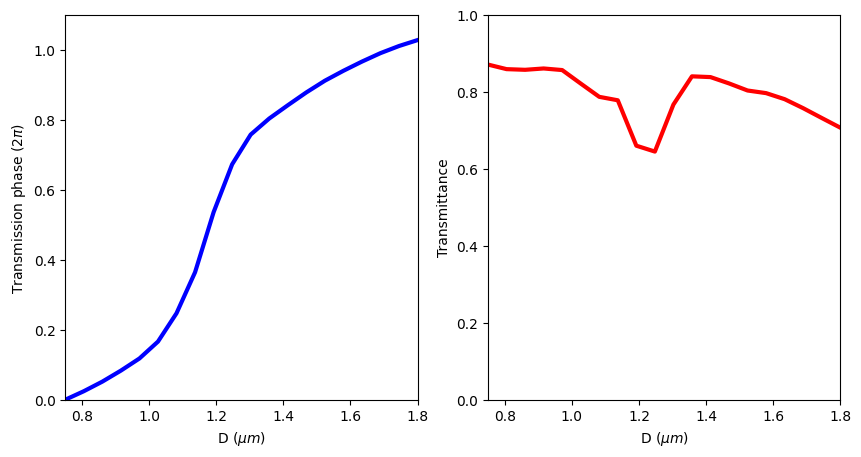

In [52]:
# Plot test for cylinders
rad_values = np.linspace(0.75, 1.8, 20)

complex_vals = []
for rad in rad_values:
    feature_array = np.array((rad, rad, 0, freq0))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)
    comp_num = prediction[0] + prediction[1] * 1j
    complex_vals.append(comp_num)

complex_arr = np.array(complex_vals)
theta = np.unwrap(np.angle(complex_arr))

# plot the transmission phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
theta = theta - theta[0]
ax1.plot(rad_values, theta / (2 * np.pi), linewidth=3, c="blue")
ax1.set_xlim(np.min(rad_values), np.max(rad_values))
ax1.set_ylim(0, 1.1)
ax1.set_xlabel("D ($\mu m$)")
ax1.set_ylabel("Transmission phase ($2\pi$)")

# plot the transmittance
ax2.plot(rad_values, np.abs(complex_arr), linewidth=3, c="red")
ax2.set_xlim(np.min(rad_values), np.max(rad_values))
ax2.set_ylim(0, 1)
ax2.set_xlabel("D ($\mu m$)")
ax2.set_ylabel("Transmittance")
plt.show()

In [74]:
# ideal_structures = np.zeros(shape=(phi_map.shape[0], phi_map.shape[1], 4))
# for i in range(len(phi_map)):
#     for j in range(len(phi_map)):
#         target_phi = phi_map[i][j]
        
#         # Design space defined new each time 
#         method = tdd.MethodBayOpt(
#             initial_iter=200,
#             n_iter=10,
#             acq_func='ucb',
#             kappa=3,
#             xi=0.9,
#             seed=1,
#         )

#         # Easiest way to get target_phi into the optimization
#         predict_parameters = parameters + [tdd.ParameterFloat(name="target_phi", span=(target_phi, target_phi))]

#         output_dir = "/home/matt/Documents/Flexcompute/metalens2/data"
#         design_space = tdd.DesignSpace(
#             method=method,
#             parameters=predict_parameters,
#             task_name="metalens_predict_1",
#             folder_name="MetalensV2",
#             path_dir=output_dir,
#         )
        
#         predict_results = design_space.run(run_fn, verbose=False)
#         ideal_structures[i][j] = np.array(list(predict_results.optimizer.max['params'].values()))

# # create pillar geometries at each cell to follow the desired phase profile
# ellipsis_structures = []
# for i, x in enumerate(r):
#     for j, y in enumerate(r):
#         if x**2 + y**2 <= R**2 and x >= 0 and y >= 0:
#             ideal_params = ideal_structures[i][j]
#             # BayOpt outputs params in alphabetical order
#             ellipsis = create_ellipsis(ideal_params[1], ideal_params[2], ideal_params[0], x, y)
#             ellipsis_structures.append(ellipsis)


In [71]:
import xarray
coords = {"phi": list(phi_dict.keys())}
dims = ["phi", "row"]
data = np.array([np.array(list(row)) for row in phi_dict.values()])
phi_array = xarray.DataArray(data=data, coords=coords, dims=dims)

# print(phi_array.sel(phi=3.11, method="nearest"))

os.chdir("/home/matt/Documents/Flexcompute/metalens_linear_source/data")
with open("phi_array.pkl", "wb") as out_file:
    pickle.dump(phi_array, out_file)

# with open("phi_array.pkl", "rb") as in_file:
#     phi_array = pickle.load(in_file)


Make output an xarray and then use .sel nearest to pick the appropriate structures
Wonder if just taking abs of x and y offsets would fix positioning issue?

Build the simulation from the ideal structures https://www.flexcompute.com/tidy3d/examples/notebooks/MidIRMetalens/

In [72]:
# create pillar geometries at each cell to follow the desired phase profile
ellipsis_structures = []
for i, x in enumerate(r):
    for j, y in enumerate(r):
        if x**2 + y**2 <= R**2 and x >= 0 and y >= 0:
            ideal_params = phi_array.sel(phi=phi_map[i][j], method="nearest").data
            # BayOpt outputs params in alphabetical order
            ellipsis = create_ellipsis(ideal_params[1], ideal_params[2], ideal_params[0], x, y)
            ellipsis_structures.append(ellipsis)


In [73]:
# simulation domain size
Lx = 2 * R + lda0
Ly = 2 * R + lda0
Lz = h + 1.3 * lda0

# grids of the projected field position
xs_far = np.linspace(-3 * lda0, 3 * lda0, 101)
ys_far = np.linspace(-3 * lda0, 3 * lda0, 101)

# define a field projection monitor
monitor_proj = td.FieldProjectionCartesianMonitor(
    center=[0, 0, h + 0.6 * lda0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="focal_plane_proj",
    proj_axis=2,
    proj_distance=f,
    x=xs_far,
    y=ys_far,
    custom_origin=(0, 0, 0),
    far_field_approx=False,
)

# define geometry
substrate_geo = td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0))
substrate = td.Structure(geometry=substrate_geo, medium=si, name="substrate")

# add a plane wave source
plane_wave1 = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -0.1 * lda0),
    direction="+",
)

run_time = 5e-12  # simulation run time
min_steps_per_wvl = 12

# define the simulation
metalens_sim = td.Simulation(
    center=(0, 0, Lz / 2 - lda0 / 2),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0),
    structures=ellipsis_structures + [substrate],
    sources=[plane_wave1],
    monitors=[monitor_proj],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()),
    symmetry=(-1, 1, 0),
)

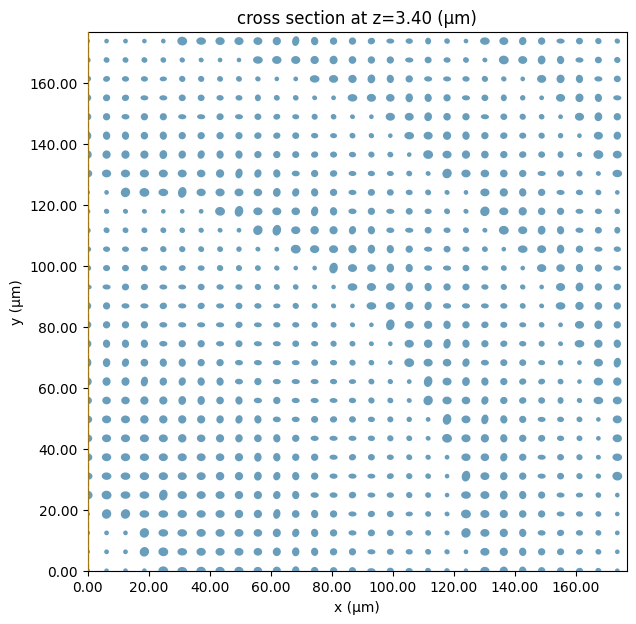

In [74]:
fig, ax = plt.subplots(figsize=(7, 7))
metalens_sim.plot(z=h / 2, ax=ax)
ax.set_xlim(0, R/3)
ax.set_ylim(0, R/3)
plt.show()

In [61]:
import tidy3d.web as web
job = web.Job(simulation=metalens_sim, task_name="ir_metalens")
estimated_cost = web.estimate_cost(job.task_id)

11:54:48 BST Created task 'ir_metalens' with task_id                            
             'fdve-7bd13498-91a0-4491-8c03-e8526f71b8da' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=626869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bd13498-91a0-4491-8c03-e8526f71b8da\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=585661;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bd13498-91a0-4491-8c03-e8526f71b8da\taskId]8;;\]8;id=626869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bd13498-91a0-4491-8c03-e8526f71b8da\=]8;;\]8;id=901318;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bd13498-91a0-4491-8c03-e8526f71b8da\fdve]8;;\]8;id=626869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bd13498-91a0-4491-8c03-e8526f71b8da\-7bd13498-91a]8;;\
             ]8;id=626869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bd13498-91a0-4491-8c03-e8526f71b8da\0-4491-8c03-e8526f71b8da']8;;\.

Output()

11:55:17 BST Maximum FlexCredit cost: 2.903. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

               0.111 FlexCredit of the total cost from post-processing.

In [75]:
sim_data = web.run(metalens_sim, task_name="metalens_full_sim")

13:39:27 BST Created task 'metalens_full_sim' with task_id                      
             'fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=184213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=649028;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\taskId]8;;\]8;id=184213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\=]8;;\]8;id=583493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\fdve]8;;\]8;id=184213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\-b4b2fe07-12d]8;;\
             ]8;id=184213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\0-451a-bd3e-45b5c7b16170']8;;\.

Output()

13:39:42 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:41:03 BST status = preprocess

13:41:40 BST Maximum FlexCredit cost: 2.899. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

14:08:45 BST early shutoff detected at 60%, exiting.

             status = postprocess

Output()

14:08:51 BST status = success

             View simulation result at                                          
             ]8;id=264616;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=642455;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\taskId]8;;\]8;id=264616;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\=]8;;\]8;id=804510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\fdve]8;;\]8;id=264616;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\-b4b2fe07-12d]8;;\
             ]8;id=264616;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b4b2fe07-12d0-451a-bd3e-45b5c7b16170\0-451a-bd3e-45b5c7b16170']8;;\.

Output()

14:08:57 BST loading simulation from simulation_data.hdf5

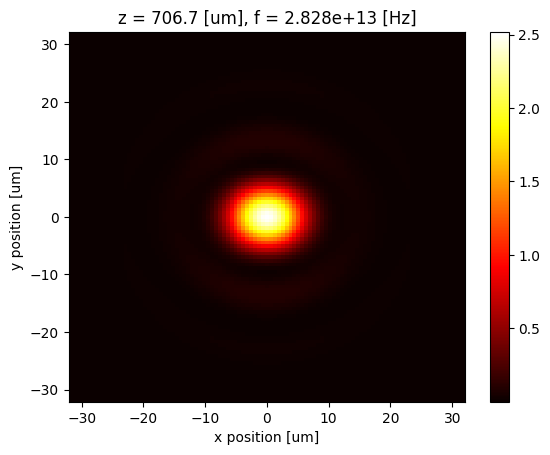

In [80]:
proj_fields = sim_data["focal_plane_proj"].fields_cartesian.sel(f=freq0)

# compute the intensity of the field
I = np.abs(proj_fields.Ex) ** 2 + np.abs(proj_fields.Ey) ** 2 + np.abs(proj_fields.Ez) ** 2

# plot field distribution
I.plot(x="x", y="y", cmap="hot")
plt.show()

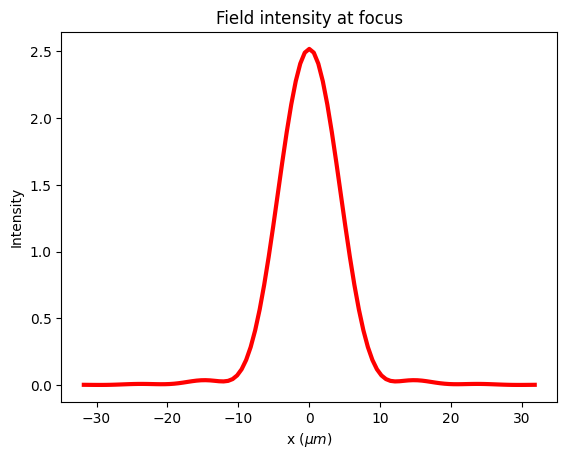

Max I: <xarray.DataArray ()> Size: 8B
array(2.51717958)
Coordinates:
    y        float64 8B -3.553e-15
    z        float64 8B 706.7
    f        float64 8B 2.828e+13
The FWHM is 10.176 um. Wavelength was 10.6 um.


In [82]:
I_x = I.sel(y=0, z=f, method="nearest")  # extract the field intensity in the x direction

# plot the intensity profile
fig, ax = plt.subplots()
I_x.plot(linewidth=3, c="red", ax=ax)
ax.set_ylabel("Intensity")
ax.set_xlabel("x ($\mu m$)")
ax.set_title("Field intensity at focus")
plt.show()

print(f"Max I: {I_x.max()}")

# function for determining the fwhm
def cal_fwhm(x, y):

    # filter the data
    y = y[x > 0]
    x = x[x > 0]
    x = x[y > 0.4 * np.max(y)]
    y = y[y > 0.4 * np.max(y)]

    # compute half width by interpolation
    hm_point = np.interp(np.max(y) / 2, y, x)

    # compute full width
    fwhm_value = 2 * hm_point

    return fwhm_value

# calculate fwhm
fwhm = cal_fwhm(I_x.x.values, I_x.values)
print(f"The FWHM is {fwhm:.3f} um. Wavelength was {lda0} um.")